In [18]:
# %pip install numpy torch torchvision scikit-learn matplotlib pillow 
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image

In [20]:
import torch
print(torch.__version__)
print(torch.version.cuda)

2.4.0+cu118
11.8


In [21]:
import torch
print(torch.cuda.is_available())

True


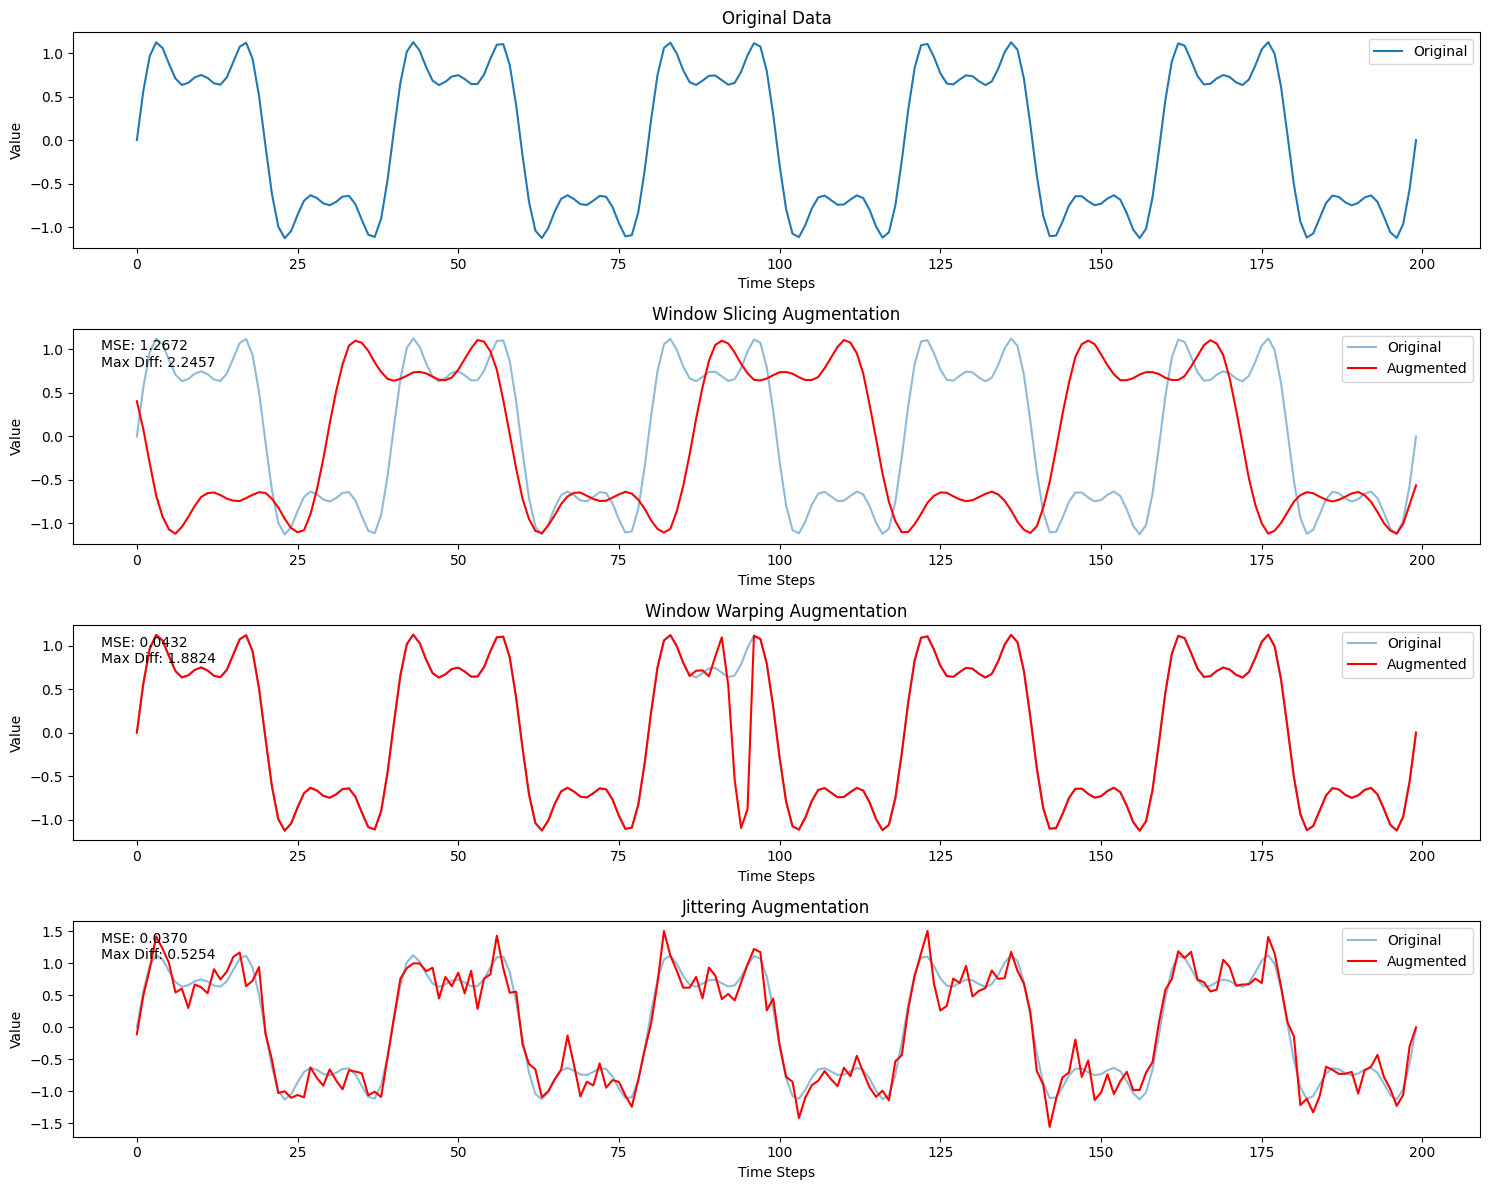

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.169412].


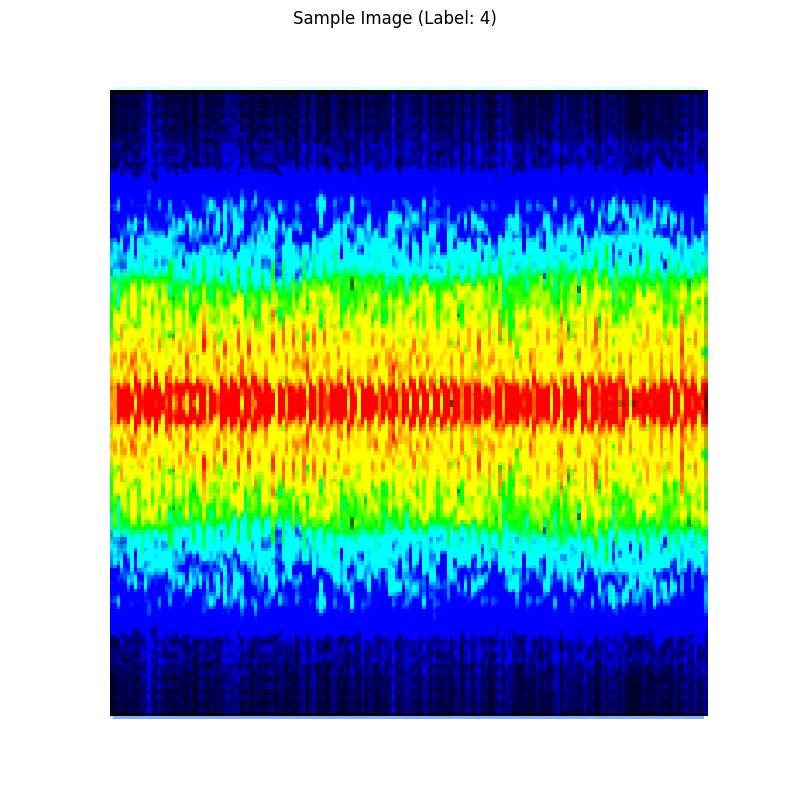

Dataset Details:
Total Images: 4849
Training Images: 4121
Validation Images: 242
Test Images: 486


In [22]:
# %% [markdown]
# # Time-Variant Data Augmentation Techniques

# %% Imports
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# %% Time-Variant Data Augmentation Techniques
class TimeVariantDataAugmentation:
    @staticmethod
    def window_slicing(data, slice_percentage=0.9):
        """
        Perform window slicing on time-variant data
        
        Args:
            data (torch.Tensor): Input time-variant data
            slice_percentage (float): Percentage of original width to keep (default: 0.9)
        
        Returns:
            torch.Tensor: Augmented time-variant data
        """
        # Ensure input is a torch tensor
        if not isinstance(data, torch.Tensor):
            data = torch.tensor(data, dtype=torch.float32)
        
        # Get original dimensions
        orig_width = data.shape[1]
        
        # Calculate slice width
        slice_width = int(orig_width * slice_percentage)
        
        # Generate random starting point
        max_start = orig_width - slice_width
        start_point = torch.randint(0, max_start + 1, (1,)).item()
        
        # Extract slice
        sliced_data = data[:, start_point:start_point + slice_width]
        
        # Interpolate back to original size
        augmented_data = torch.nn.functional.interpolate(
            sliced_data.unsqueeze(0), 
            size=orig_width, 
            mode='linear', 
            align_corners=False
        ).squeeze(0)
        
        return augmented_data

    @staticmethod
    def window_warping(data, warping_factors=[0.5, 2.0]):
        """
        Perform window warping on time-variant data
        
        Args:
            data (torch.Tensor): Input time-variant data
            warping_factors (list): Warping factors to apply (default: [0.5, 2.0])
        
        Returns:
            torch.Tensor: Augmented time-variant data
        """
        # Ensure input is a torch tensor
        if not isinstance(data, torch.Tensor):
            data = torch.tensor(data, dtype=torch.float32)
        
        # Get original dimensions
        orig_width = data.shape[1]
        
        # Select window (10% of original width)
        window_width = int(orig_width * 0.1)
        start_point = torch.randint(0, orig_width - window_width + 1, (1,)).item()
        
        # Select random warping factor
        warping_factor = np.random.choice(warping_factors)
        
        # Extract window
        window = data[:, start_point:start_point + window_width]
        
        # Warp window
        warped_window_width = int(window_width * warping_factor)
        warped_window = torch.nn.functional.interpolate(
            window.unsqueeze(0), 
            size=warped_window_width, 
            mode='linear', 
            align_corners=False
        ).squeeze(0)
        
        # Reconstruct full data
        augmented_data = data.clone()
        end_point = start_point + warped_window_width
        
        # Replace window section with warped window
        if warped_window_width < window_width:
            augmented_data[:, start_point:end_point] = warped_window
        else:
            augmented_data[:, start_point:start_point + window_width] = warped_window[:window_width]
        
        return augmented_data

    @staticmethod
    def jittering(data, mean=0, std_dev=0.03):
        """
        Add Gaussian noise to time-variant data
        
        Args:
            data (torch.Tensor): Input time-variant data
            mean (float): Mean of Gaussian noise
            std_dev (float): Standard deviation of Gaussian noise
        
        Returns:
            torch.Tensor: Augmented time-variant data
        """
        # Ensure input is a torch tensor
        if not isinstance(data, torch.Tensor):
            data = torch.tensor(data, dtype=torch.float32)
        
        # Generate Gaussian noise
        noise = torch.normal(mean, std_dev, size=data.shape)
        
        # Add noise to original data
        augmented_data = data + noise
        
        return augmented_data

# %% Stochastic Augmentation Class
class StochasticAugmentation:
    def __init__(self, augmentation_methods):
        """
        Create a stochastic augmentation pipeline
        
        Args:
            augmentation_methods (list): List of augmentation methods to choose from
        """
        self.augmentation_methods = augmentation_methods
    
    def __call__(self, data):
        """
        Randomly select and apply one augmentation method
        
        Args:
            data (torch.Tensor): Input time-variant data
        
        Returns:
            torch.Tensor: Augmented time-variant data
        """
        # Randomly select an augmentation method
        method = np.random.choice(self.augmentation_methods)
        
        # Apply the selected method
        return method(data)

# %% Custom Image Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, base_dir, subfolders, transform=None, label_encoder=None):
        self.base_dir = base_dir
        self.subfolders = subfolders
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for subfolder in subfolders:
            folder_path = os.path.join(base_dir, subfolder)
            label = subfolder
            
            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(folder_path, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(label)
        
        if label_encoder is not None:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.labels)
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

# %% Augmentation Visualization Function
def visualize_augmentation():
    # Create more complex sample data with multiple frequencies
    t = torch.linspace(0, 10*torch.pi, 200)
    sample_data = torch.sin(t) + 0.5 * torch.sin(3*t) + 0.25 * torch.sin(5*t)
    sample_data = sample_data.unsqueeze(0)
    
    # Create augmentation methods with specific transformations
    augmentation_methods = [
        ("Window Slicing", lambda x: TimeVariantDataAugmentation.window_slicing(x, slice_percentage=0.7)),
        ("Window Warping", lambda x: TimeVariantDataAugmentation.window_warping(x, warping_factors=[0.5])),
        ("Jittering", lambda x: TimeVariantDataAugmentation.jittering(x, mean=0, std_dev=0.2))
    ]
    
    # Visualization
    plt.figure(figsize=(15, 12))
    
    # Original Data
    plt.subplot(4, 1, 1)
    plt.title("Original Data")
    plt.plot(sample_data.numpy().flatten(), label='Original')
    plt.legend()
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    
    # Augmentations with Difference Plots
    for i, (name, aug_method) in enumerate(augmentation_methods, start=2):
        # Apply augmentation
        augmented_data = aug_method(sample_data)
        
        # Augmented Data Subplot
        plt.subplot(4, 1, i)
        plt.title(f"{name} Augmentation")
        plt.plot(sample_data.numpy().flatten(), label='Original', alpha=0.5)
        plt.plot(augmented_data.numpy().flatten(), label='Augmented', color='red')
        plt.legend()
        plt.xlabel("Time Steps")
        plt.ylabel("Value")
        
        # Calculate and display difference metrics
        mse = torch.nn.functional.mse_loss(sample_data, augmented_data).item()
        max_diff = torch.max(torch.abs(augmented_data - sample_data)).item()
        
        plt.text(0.02, 0.95, f"MSE: {mse:.4f}\nMax Diff: {max_diff:.4f}", 
                 transform=plt.gca().transAxes, 
                 verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

# %% Define dataset parameters
base_dir = r'DIAT-uSAT_dataset'
subfolders = [
    "3_long_blade_rotor",
    "3_short_blade_rotor", 
    "Bird", 
    "Bird+mini-helicopter", 
    "drone", 
    "rc_plane"
]

# %% Prepare Label Encoder
label_encoder = LabelEncoder()
label_encoder.fit(subfolders)

# %% Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# %% Load dataset
dataset = CustomImageDataset(base_dir, subfolders, transform=transform, label_encoder=label_encoder)

# %% Seed and shuffle
torch.manual_seed(42)
indices = torch.randperm(len(dataset))
shuffled_dataset = Subset(dataset, indices)

# %% Split dataset
train_size = int(0.85 * len(shuffled_dataset))
val_size = int(0.05 * len(shuffled_dataset))
test_size = len(shuffled_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(shuffled_dataset, [train_size, val_size, test_size])

# %% Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# %% Visualize Augmentation
visualize_augmentation()

# %% Visualize one sample from dataset
sample_image, sample_label = next(iter(train_loader))
sample_image = sample_image[0]
sample_image = sample_image.permute(1, 2, 0)

plt.figure(figsize=(10, 10))
plt.imshow(sample_image)
plt.title(f"Sample Image (Label: {sample_label[0]})")
plt.axis('off')
plt.show()

# %% Print dataset details
print("Dataset Details:")
print(f"Total Images: {len(dataset)}")
print(f"Training Images: {len(train_dataset)}")
print(f"Validation Images: {len(val_dataset)}")
print(f"Test Images: {len(test_dataset)}")

In [23]:
# Load dataset
dataset = CustomImageDataset(base_dir, subfolders, transform=transform, label_encoder=label_encoder)

In [24]:
torch.manual_seed(42) 
indices = torch.randperm(len(dataset)) 
shuffled_dataset = torch.utils.data.Subset(dataset, indices)

In [25]:
train_size = int(0.85 * len(shuffled_dataset))
val_size = int(0.05 * len(shuffled_dataset))
test_size = len(shuffled_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(shuffled_dataset, [train_size, val_size, test_size])

In [26]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.5005665].


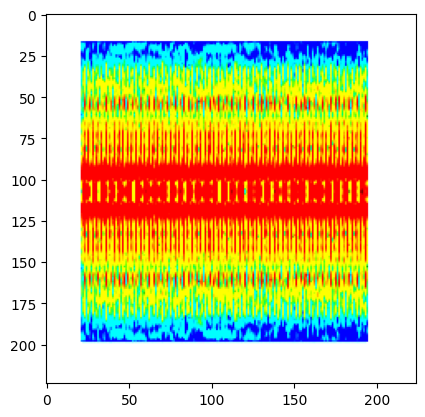

In [27]:
# Visualize one sample
sample_image, sample_label = next(iter(train_loader))
sample_image = sample_image[0] 
sample_image = sample_image.permute(1, 2, 0)  

plt.imshow(sample_image)
plt.show()

In [28]:
# Model definitions using VGG16 and VGG19
class CustomVGG(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomVGG, self).__init__()
        self.features = base_model.features
        self.avgpool = base_model.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(base_model.classifier[0].in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Initialize models
vgg16_base = models.vgg16(pretrained=True)
for param in vgg16_base.parameters():
    param.requires_grad = False
model_vgg16 = CustomVGG(vgg16_base, num_classes=6)

vgg19_base = models.vgg19(pretrained=True)
for param in vgg19_base.parameters():
    param.requires_grad = False
model_vgg19 = CustomVGG(vgg19_base, num_classes=6)

c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1

In [9]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg16.to(device)
model_vgg19.to(device)

CustomVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)

In [10]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_vgg16 = optim.Adam(model_vgg16.classifier.parameters(), lr=0.0001)
optimizer_vgg19 = optim.Adam(model_vgg19.classifier.parameters(), lr=0.0001)

In [11]:
# Learning rate scheduler
scheduler_vgg16 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_vgg16, mode='min', factor=0.5, patience=2, min_lr=1e-7, verbose=True)
scheduler_vgg19 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_vgg19, mode='min', factor=0.5, patience=2, min_lr=1e-7, verbose=True)

c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [15]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15):
    model.train()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device, dtype=torch.long)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device, dtype=torch.long)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * images.size(0)
                val_corrects += torch.sum(preds == labels.data)
        
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
        
        scheduler.step(val_loss)
        
        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_model_{model.__class__.__name__}.pt")
        
        model.train()

In [13]:
# Train VGG16 model
train_model(model_vgg16, train_loader, val_loader, criterion, optimizer_vgg16, scheduler_vgg16)

Epoch [1/15], Loss: 0.4387, Accuracy: 0.8459
Validation Loss: 0.1879, Accuracy: 0.9215
Epoch [2/15], Loss: 0.1855, Accuracy: 0.9425
Validation Loss: 0.0998, Accuracy: 0.9793
Epoch [3/15], Loss: 0.1367, Accuracy: 0.9537
Validation Loss: 0.0645, Accuracy: 0.9917
Epoch [4/15], Loss: 0.1050, Accuracy: 0.9675
Validation Loss: 0.0616, Accuracy: 0.9793
Epoch [5/15], Loss: 0.0901, Accuracy: 0.9709
Validation Loss: 0.0399, Accuracy: 0.9959
Epoch [6/15], Loss: 0.0734, Accuracy: 0.9745
Validation Loss: 0.0526, Accuracy: 0.9917
Epoch [7/15], Loss: 0.0736, Accuracy: 0.9748
Validation Loss: 0.0418, Accuracy: 0.9876
Epoch [8/15], Loss: 0.0603, Accuracy: 0.9803
Validation Loss: 0.0782, Accuracy: 0.9752
Epoch [9/15], Loss: 0.0356, Accuracy: 0.9903
Validation Loss: 0.0259, Accuracy: 0.9959
Epoch [10/15], Loss: 0.0306, Accuracy: 0.9903
Validation Loss: 0.0311, Accuracy: 0.9876
Epoch [11/15], Loss: 0.0291, Accuracy: 0.9908
Validation Loss: 0.0225, Accuracy: 0.9959
Epoch [12/15], Loss: 0.0274, Accuracy: 0.

In [14]:
train_model(model_vgg19, train_loader, val_loader, criterion, optimizer_vgg19, scheduler_vgg19)

Epoch [1/15], Loss: 0.5034, Accuracy: 0.8258
Validation Loss: 0.1776, Accuracy: 0.9463
Epoch [2/15], Loss: 0.2490, Accuracy: 0.9177
Validation Loss: 0.1134, Accuracy: 0.9835
Epoch [3/15], Loss: 0.1818, Accuracy: 0.9386
Validation Loss: 0.1015, Accuracy: 0.9752
Epoch [4/15], Loss: 0.1532, Accuracy: 0.9515
Validation Loss: 0.0834, Accuracy: 0.9793
Epoch [5/15], Loss: 0.1325, Accuracy: 0.9510
Validation Loss: 0.0872, Accuracy: 0.9711
Epoch [6/15], Loss: 0.1145, Accuracy: 0.9607
Validation Loss: 0.0656, Accuracy: 0.9793
Epoch [7/15], Loss: 0.0957, Accuracy: 0.9689
Validation Loss: 0.0540, Accuracy: 0.9876
Epoch [8/15], Loss: 0.0902, Accuracy: 0.9704
Validation Loss: 0.0803, Accuracy: 0.9793
Epoch [9/15], Loss: 0.0785, Accuracy: 0.9750
Validation Loss: 0.0498, Accuracy: 0.9793
Epoch [10/15], Loss: 0.0684, Accuracy: 0.9784
Validation Loss: 0.0535, Accuracy: 0.9835
Epoch [11/15], Loss: 0.0639, Accuracy: 0.9777
Validation Loss: 0.0424, Accuracy: 0.9876
Epoch [12/15], Loss: 0.0653, Accuracy: 0.

In [16]:
import torch
from sklearn.metrics import classification_report

def test_model(model, test_loader, criterion, class_names=None):
    """
    Test the model on a test set and generate metrics.
    
    Args:
        model (torch.nn.Module): The trained model.
        test_loader (DataLoader): DataLoader for the test set.
        criterion (torch.nn.Module): Loss function.
        class_names (list): Optional list of class names for the report.
        
    Returns:
        all_labels (list): True labels for the test set.
        all_preds (list): Predicted labels for the test set.
    """
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    test_acc = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation for inference
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.long)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            test_acc += torch.sum(preds == labels).item()
            
            # Collect all predictions and labels for the classification report
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_acc / len(test_loader.dataset)

    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

    return all_labels, all_preds


In [16]:
# Test model with model_vgg16
all_labels_vgg16, all_preds_vgg16 = test_model(model_vgg16, test_loader, criterion)

# Test model with model_vgg19
all_labels_vgg19, all_preds_vgg19 = test_model(model_vgg19, test_loader, criterion)

# Ensure class_names is defined using the label encoder or fallback to numeric class names
if 'label_encoder' in locals() and hasattr(label_encoder, 'classes_'):
    class_names = label_encoder.classes_
else:
    # Create class names based on unique labels found in the dataset
    class_names = [str(i) for i in range(max(max(all_labels_vgg16), max(all_labels_vgg19)) + 1)]

# Generate and print the classification report for model_vgg16
report_vgg16 = classification_report(all_labels_vgg16, all_preds_vgg16, target_names=class_names)
print("Classification Report for VGG16:")
print(report_vgg16)

# Generate and print the classification report for model_vgg19
report_vgg19 = classification_report(all_labels_vgg19, all_preds_vgg19, target_names=class_names)
print("Classification Report for VGG19:")
print(report_vgg19)

Test Loss: 0.0237, Accuracy: 0.9938
Test Loss: 0.0554, Accuracy: 0.9835
Classification Report for VGG16:
                      precision    recall  f1-score   support

  3_long_blade_rotor       1.00      1.00      1.00        72
 3_short_blade_rotor       0.99      0.99      0.99        85
                Bird       1.00      1.00      1.00        76
Bird+mini-helicopter       0.99      1.00      0.99        78
               drone       1.00      1.00      1.00        85
            rc_plane       0.99      0.98      0.98        90

            accuracy                           0.99       486
           macro avg       0.99      0.99      0.99       486
        weighted avg       0.99      0.99      0.99       486

Classification Report for VGG19:
                      precision    recall  f1-score   support

  3_long_blade_rotor       0.93      0.99      0.96        72
 3_short_blade_rotor       1.00      0.96      0.98        85
                Bird       1.00      1.00      1.00 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 2nd Convolutional Block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3rd Convolutional Block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 4th Convolutional Block
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, 6)  # Output for 6 classes

        # Dropout for Regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # 1st Convolutional Block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        # 2nd Convolutional Block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # 3rd Convolutional Block
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # 4th Convolutional Block
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        # Global Average Pooling
        x = self.global_avg_pool(x)
        
        # Flatten the output
        x = torch.flatten(x, 1)
        
        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


In [18]:
# Initialize Deeper CNN model
model_deepercnn = CustomCNN(num_classes=6)
model_deepercnn.to(device)

CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [19]:
# Loss and optimizer for Deeper CNN
optimizer_deepercnn = optim.Adam(model_deepercnn.parameters(), lr=0.0001)
scheduler_deepercnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_deepercnn, mode='min', factor=0.5, patience=2, min_lr=1e-7, verbose=True)

c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [20]:
# Train Deeper CNN model
train_model(model_deepercnn, train_loader, val_loader, criterion, optimizer_deepercnn, scheduler_deepercnn, num_epochs=20)

Epoch [1/20], Loss: 1.1221, Accuracy: 0.6205
Validation Loss: 0.5616, Accuracy: 0.7893
Epoch [2/20], Loss: 0.6146, Accuracy: 0.7896
Validation Loss: 0.3828, Accuracy: 0.8471
Epoch [3/20], Loss: 0.4768, Accuracy: 0.8347
Validation Loss: 0.2460, Accuracy: 0.9421
Epoch [4/20], Loss: 0.3915, Accuracy: 0.8656
Validation Loss: 0.2009, Accuracy: 0.9380
Epoch [5/20], Loss: 0.3278, Accuracy: 0.8944
Validation Loss: 0.2096, Accuracy: 0.9215
Epoch [6/20], Loss: 0.3002, Accuracy: 0.8978
Validation Loss: 0.1558, Accuracy: 0.9504
Epoch [7/20], Loss: 0.2563, Accuracy: 0.9221
Validation Loss: 0.1342, Accuracy: 0.9504
Epoch [8/20], Loss: 0.2430, Accuracy: 0.9194
Validation Loss: 0.4780, Accuracy: 0.8058
Epoch [9/20], Loss: 0.2330, Accuracy: 0.9267
Validation Loss: 0.1158, Accuracy: 0.9504
Epoch [10/20], Loss: 0.2068, Accuracy: 0.9333
Validation Loss: 0.0878, Accuracy: 0.9711
Epoch [11/20], Loss: 0.1878, Accuracy: 0.9435
Validation Loss: 0.1289, Accuracy: 0.9545
Epoch [12/20], Loss: 0.1661, Accuracy: 0.

In [21]:
# Test the custom CNN model
all_labels_customcnn, all_preds_customcnn = test_model(model_deepercnn, test_loader, criterion)

# Ensure class_names is defined using the label encoder or fallback to numeric class names
if 'label_encoder' in locals() and hasattr(label_encoder, 'classes_'):
    class_names = label_encoder.classes_
else:
    # Create class names based on unique labels found in the dataset
    class_names = [str(i) for i in range(max(all_labels_customcnn) + 1)]

# Generate and print the classification report for the custom CNN
report_customcnn = classification_report(all_labels_customcnn, all_preds_customcnn, target_names=class_names)
print("Classification Report for Custom CNN:")
print(report_customcnn)

Test Loss: 0.1258, Accuracy: 0.9630
Classification Report for Custom CNN:
                      precision    recall  f1-score   support

  3_long_blade_rotor       0.92      0.96      0.94        72
 3_short_blade_rotor       1.00      0.82      0.90        85
                Bird       1.00      1.00      1.00        76
Bird+mini-helicopter       0.95      1.00      0.97        78
               drone       1.00      1.00      1.00        85
            rc_plane       0.92      1.00      0.96        90

            accuracy                           0.96       486
           macro avg       0.96      0.96      0.96       486
        weighted avg       0.97      0.96      0.96       486



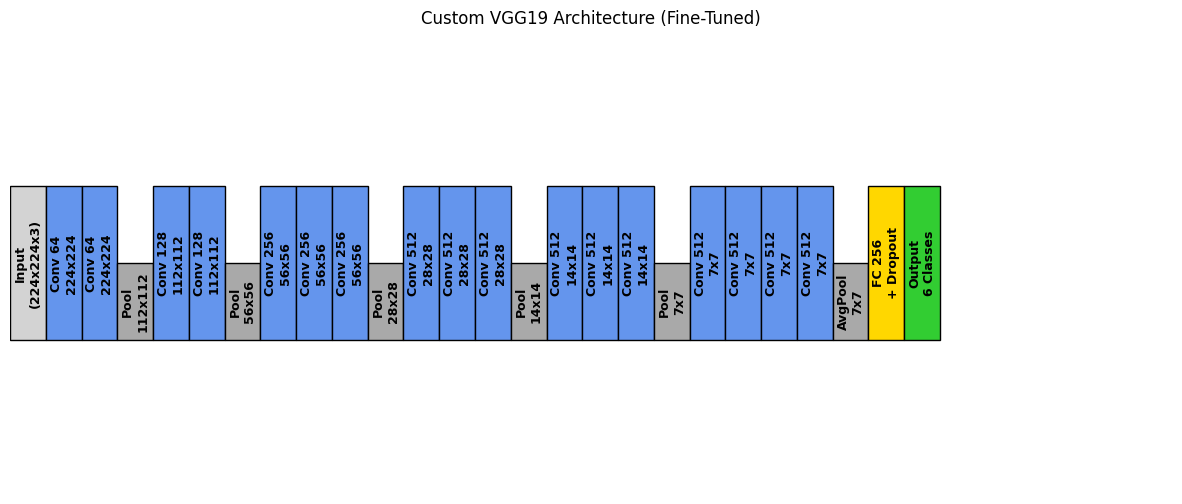

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


fig, ax = plt.subplots(figsize=(15, 6))


colors = {
    'input': '#d3d3d3',  # Light gray for Input Layer
    'conv': '#6495ed',   # Blue for Convolution + ReLU
    'pool': '#a9a9a9',   # Dark gray for Max Pooling
    'dense': '#ffd700',  # Gold for Fully Connected + ReLU
    'output': '#32cd32'  # Lime for Output (softmax)
}

def draw_block(ax, x, y, width, height, label, color):
    rect = patches.Rectangle((x, y), width, height, edgecolor='black', facecolor=color)
    ax.add_patch(rect)

    ax.text(x + width / 2, y + height / 2, label, color='black',
            ha='center', va='center', fontsize=9, weight="bold", rotation=90)

block_width = 0.4


draw_block(ax, 0, 1, block_width, 1, 'Input\n(224x224x3)', colors['input'])

# Conv + ReLU Layers
conv_layers = [
    ('Conv 64\n224x224', block_width), ('Conv 64\n224x224', block_width), ('Pool\n112x112', block_width),
    ('Conv 128\n112x112', block_width), ('Conv 128\n112x112', block_width), ('Pool\n56x56', block_width),
    ('Conv 256\n56x56', block_width), ('Conv 256\n56x56', block_width), ('Conv 256\n56x56', block_width), ('Pool\n28x28', block_width),
    ('Conv 512\n28x28', block_width), ('Conv 512\n28x28', block_width), ('Conv 512\n28x28', block_width), ('Pool\n14x14', block_width),
    ('Conv 512\n14x14', block_width), ('Conv 512\n14x14', block_width), ('Conv 512\n14x14', block_width), ('Pool\n7x7', block_width),
    ('Conv 512\n7x7', block_width), ('Conv 512\n7x7', block_width), ('Conv 512\n7x7', block_width), ('Conv 512\n7x7', block_width)  # Additional layers
]

x_offset = block_width
for layer, width in conv_layers:
    if 'Conv' in layer:
        draw_block(ax, x_offset, 1, width, 1, layer, colors['conv'])
    else:  
        draw_block(ax, x_offset, 1, width, 0.5, layer, colors['pool'])
    x_offset += width

# Adaptive Average Pooling
draw_block(ax, x_offset, 1, block_width, 0.5, 'AvgPool\n7x7', colors['pool'])
x_offset += block_width

# Fully Connected + Dropout + ReLU Layers
draw_block(ax, x_offset, 1, block_width, 1, 'FC 256\n+ Dropout', colors['dense'])
x_offset += block_width

# Output Layer
draw_block(ax, x_offset, 1, block_width, 1, 'Output\n6 Classes', colors['output'])


ax.set_xlim(0, x_offset + 3)
ax.set_ylim(0, 3)
ax.axis('off')


plt.title('Custom VGG19 Architecture (Fine-Tuned)')
plt.show()

In [23]:
import torch
import torchvision.models as models

# Define your CustomVGG class as before
class CustomVGG(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomVGG, self).__init__()
        self.features = base_model.features
        self.avgpool = base_model.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(base_model.classifier[0].in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Load the base VGG19 model
vgg19_base = models.vgg19(pretrained=True)

# Initialize your CustomVGG model
num_classes = 6
model = CustomVGG(vgg19_base, num_classes)

# Load the saved state_dict
model.load_state_dict(torch.load('best_model_CustomVGG.pt'))
model.eval()  # Set the model to evaluation mode

# Convert to TorchScript
scripted_model = torch.jit.script(model)

# Save the scripted model
torch.jit.save(scripted_model, 'scripted_model_CustomVGG.pt')


c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\incha\AppData\Local\Temp\ipykernel_30612\996431065.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (S

In [24]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define your CustomVGG class
class CustomVGG(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomVGG, self).__init__()
        self.features = base_model.features
        self.avgpool = base_model.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(base_model.classifier[0].in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Load the base VGG16 model
vgg16_base = models.vgg16(pretrained=True)

# Initialize your CustomVGG model
num_classes = 6
model = CustomVGG(vgg16_base, num_classes)

# Load the saved state_dict with strict=False
try:
    model.load_state_dict(torch.load('best_model_CustomVGG.pt'), strict=False)
except RuntimeError as e:
    print(f"Error loading state_dict: {e}")

model.eval()  # Set the model to evaluation mode

# Dynamic quantization
quantized_model = torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)

# Save the quantized model
torch.save(quantized_model.state_dict(), 'quantized_model_CustomVGG.pt')

c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\incha\AppData\Local\Temp\ipykernel_30612\4004522494.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arb

Error loading state_dict: Error(s) in loading state_dict for CustomVGG:
	size mismatch for features.19.weight: copying a param with shape torch.Size([512, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).


In [30]:
# Load the saved model state
model_deepercnn.load_state_dict(torch.load("best_model_CustomCNN.pt", map_location=device))
model_deepercnn.eval()  # Set to evaluation mode

# Script the model
scripted_model = torch.jit.script(model_deepercnn)  # Or use torch.jit.trace for static input shapes

C:\Users\incha\AppData\Local\Temp\ipykernel_1200\2254952076.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_deepercnn.load_state_dict(torch.load("best_model_Custom

In [31]:
from torch.utils.mobile_optimizer import optimize_for_mobile

# Optimize the model
optimized_model = optimize_for_mobile(scripted_model)

In [32]:
# Save the optimized model
optimized_model.save("deepercnn_mobile.pt")

In [1]:
import numpy as np
from scipy.signal import spectrogram
import cv2

# Parameters
sampling_rate = 1000  # Hz
duration = 1.0        # Signal duration in seconds
time = np.linspace(0, duration, int(sampling_rate * duration))

def generate_synthetic_signal(frequencies, num_samples=100, img_size=(128, 128)):
    dataset = []
    labels = []
    
    for _ in range(num_samples):
        # Choose a random frequency to simulate a band
        freq = np.random.choice(frequencies)
        
        # Create a sine wave and add noise
        signal = np.sin(2 * np.pi * freq * time) + np.random.normal(0, 0.2, time.shape)
        
        # Generate spectrogram
        _, _, spectro = spectrogram(signal, fs=sampling_rate)
        
        # Resize spectrogram to match model input
        resized_spectro = cv2.resize(spectro, img_size)
        dataset.append(resized_spectro)
        labels.append(frequencies.index(freq))  # Assign a class index
        
    return np.array(dataset), np.array(labels)

# Example usage
frequencies = [50, 100, 150, 200]  # Simulate four radar bands
synthetic_data, synthetic_labels = generate_synthetic_signal(frequencies, num_samples=200)
print(f"Generated data shape: {synthetic_data.shape}, Labels shape: {synthetic_labels.shape}")

Generated data shape: (200, 128, 128), Labels shape: (200,)


In [2]:
# Expand dimensions for compatibility (add a channel dimension if needed)
synthetic_data = np.expand_dims(synthetic_data, axis=-1)  # For grayscale input

In [3]:
import torch

# Path to the saved .pt file
model_path = "best_model_CustomCNN.pt"

num_classes = 6  
model = CustomCNN(num_classes=num_classes)
model.load_state_dict(torch.load(model_path))
model.eval()  

# Define a dummy input matching the input size of the model
dummy_input = torch.randn(1, 3, 224, 224)  # Batch size = 1, 3 channels, 224x224 resolution


onnx_file_path = "custom_cnn.onnx"  
torch.onnx.export(
    model,                        
    dummy_input,                   
    onnx_file_path,                
    export_params=True,            
    opset_version=11,              
    do_constant_folding=True,     
    input_names=['input'],        
    output_names=['output'],       
    dynamic_axes={                
        'input': {0: 'batch_size'}, 
        'output': {0: 'batch_size'}
    }
)

print(f"Model has been converted to ONNX and saved at {onnx_file_path}")


C:\Users\incha\AppData\Local\Temp\ipykernel_5568\4282892681.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model has been converted to ONNX and saved at custom_cnn.onnx


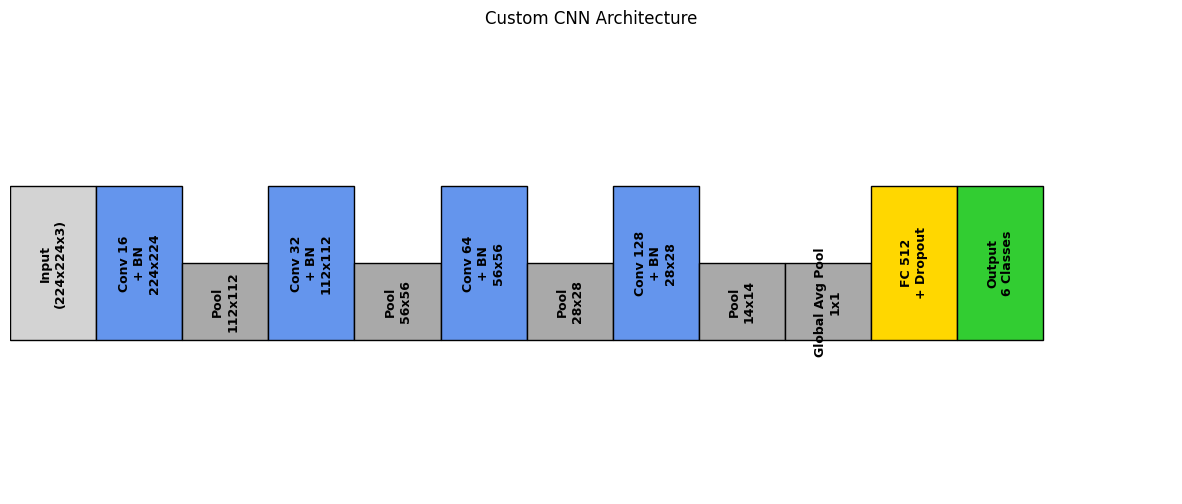

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define colors for different types of layers
colors = {
    'input': '#d3d3d3',  # Light gray for Input Layer
    'conv': '#6495ed',   # Blue for Convolution + BatchNorm + ReLU
    'pool': '#a9a9a9',   # Dark gray for Max Pooling
    'dense': '#ffd700',  # Gold for Fully Connected + ReLU
    'output': '#32cd32'  # Lime for Output
}

def draw_block(ax, x, y, width, height, label, color):
    rect = patches.Rectangle((x, y), width, height, edgecolor='black', facecolor=color)
    ax.add_patch(rect)
    ax.text(x + width / 2, y + height / 2, label, color='black',
            ha='center', va='center', fontsize=9, weight="bold", rotation=90)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

# Block dimensions
block_width = 0.4

# Draw the Input Layer
draw_block(ax, 0, 1, block_width, 1, 'Input\n(224x224x3)', colors['input'])

# Convolutional and Pooling Layers
layers = [
    ('Conv 16\n+ BN\n224x224', block_width), ('Pool\n112x112', block_width),
    ('Conv 32\n+ BN\n112x112', block_width), ('Pool\n56x56', block_width),
    ('Conv 64\n+ BN\n56x56', block_width), ('Pool\n28x28', block_width),
    ('Conv 128\n+ BN\n28x28', block_width), ('Pool\n14x14', block_width),
    ('Global Avg Pool\n1x1', block_width)
]

x_offset = block_width
for layer, width in layers:
    if 'Pool' in layer or 'Global Avg' in layer:
        height = 0.5
        draw_block(ax, x_offset, 1, width, height, layer, colors['pool'])
    else:
        height = 1
        draw_block(ax, x_offset, 1, width, height, layer, colors['conv'])
    x_offset += width

# Fully Connected Layers
draw_block(ax, x_offset, 1, block_width, 1, 'FC 512\n+ Dropout', colors['dense'])
x_offset += block_width

# Output Layer
draw_block(ax, x_offset, 1, block_width, 1, 'Output\n6 Classes', colors['output'])

# Configure plot
ax.set_xlim(0, x_offset + 1)
ax.set_ylim(0, 3)
ax.axis('off')

# Title
plt.title('Custom CNN Architecture')
plt.show()


In [12]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import time

class CustomCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 2nd Convolutional Block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3rd Convolutional Block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 4th Convolutional Block
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, 6)  # Output for 6 classes

        # Dropout for Regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # 1st Convolutional Block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        # 2nd Convolutional Block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # 3rd Convolutional Block
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # 4th Convolutional Block
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        # Global Average Pooling
        x = self.global_avg_pool(x)
        
        # Flatten the output
        x = torch.flatten(x, 1)
        
        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


# Reinitialize the model
model = CustomCNN()

# Load the state dictionary
state_dict_path = "best_model_CustomCNN.pt"
state_dict = torch.load(state_dict_path)
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

# Define the preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Define the six classes
classes = ["3 Long Blade Rotor", "3 Short Blade Rotor", "Bird", "Bird+mini-helicopter", "Drone", "RC Plane"]

# Load an image (replace with the path to your image)
image_path = "D:/Micro-Classify/ml_model/notebooks/DIAT-uSAT_dataset/3_long_blade_rotor/figure1.jpg"
image = Image.open(image_path)

# Apply the transformations
input_tensor = transform(image)

# Add a batch dimension (since PyTorch model expects a batch of images)
input_tensor = input_tensor.unsqueeze(0)  # Shape becomes (1, 3, 224, 224)

# Start timer for inference
start_time = time.time()

# Run the inference
with torch.no_grad():  # Disable gradient computation for inference
    output = model(input_tensor)

# End timer for inference
end_time = time.time()

# Calculate inference time
inference_time = end_time - start_time

# Process the output
output_probabilities = torch.nn.functional.softmax(output[0], dim=0)  # Apply softmax to get probabilities
predicted_class = torch.argmax(output_probabilities).item()  # Get index of the highest probability

# Display results
print(f"Predicted Class: {classes[predicted_class]}")
print(f"Probability: {output_probabilities[predicted_class]:.4f}")
print(f"Inference Time: {inference_time:.4f} seconds")

Predicted Class: 3 Long Blade Rotor
Probability: 0.6778
Inference Time: 0.0242 seconds


C:\Users\incha\AppData\Local\Temp\ipykernel_5568\3118820349.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path)


In [13]:
import onnxruntime as ort
import numpy as np
from PIL import Image
from torchvision import transforms
import time

# Load the ONNX model
model_path = "custom_cnn.onnx"
session = ort.InferenceSession(model_path, providers=["CPUExecutionProvider"])

# Get input and output information
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
input_shape = session.get_inputs()[0].shape

# Print input shape to understand the expected input dimensions
print(f"Expected input shape: {input_shape}")

# Define the preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Define the six classes
classes = ["3 Long Blade Rotor", "3 Short Blade Rotor", "Bird", "Bird+mini-helicopter", "Drone", "RC Plane"]

# Load an image (replace with the path to your image)
image_path = "D:/Micro-Classify/ml_model/notebooks/DIAT-uSAT_dataset/3_long_blade_rotor/figure1.jpg"
image = Image.open(image_path)

# Apply the transformations
input_tensor = transform(image)

# Add a batch dimension (since ONNX model expects a batch of images)
input_tensor = input_tensor.unsqueeze(0)  # Shape becomes (1, 3, 224, 224)

# Convert the tensor to a numpy array
input_array = input_tensor.numpy()

# Start timer for inference
start_time = time.time()

# Run the inference
output = session.run([output_name], {input_name: input_array})

# End timer for inference
end_time = time.time()

# Calculate inference time
inference_time = end_time - start_time

# Process the output
output_probabilities = np.squeeze(output[0])  # Remove unnecessary dimensions
predicted_class = np.argmax(output_probabilities)  # Get index of the highest probability

# Display results
print(f"Predicted Class: {classes[predicted_class]}")
print(f"Probability: {output_probabilities[predicted_class]:.4f}")
print(f"Inference Time: {inference_time:.4f} seconds")

Expected input shape: ['batch_size', 3, 224, 224]
Predicted Class: 3 Long Blade Rotor
Probability: 1.5323
Inference Time: 0.0000 seconds


C:\Users\incha\AppData\Local\Temp\ipykernel_5568\3779679066.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_deepercnn.load_state_dict(torch.load("best_model_Cust

Test Loss: 0.0617 Test Acc: 0.9794
Average Inference Time per Batch: 0.1849 seconds

Classification Report:
{'3 Long Blade Rotor': {'precision': 0.971830985915493, 'recall': 0.9583333333333334, 'f1-score': 0.965034965034965, 'support': 72.0}, '3 Short Blade Rotor': {'precision': 0.975609756097561, 'recall': 0.9411764705882353, 'f1-score': 0.9580838323353293, 'support': 85.0}, 'Bird': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 76.0}, 'Bird+mini-helicopter': {'precision': 0.9871794871794872, 'recall': 0.9871794871794872, 'f1-score': 0.9871794871794872, 'support': 78.0}, 'Drone': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 85.0}, 'RC Plane': {'precision': 0.9468085106382979, 'recall': 0.9888888888888889, 'f1-score': 0.967391304347826, 'support': 90.0}, 'accuracy': 0.9794238683127572, 'macro avg': {'precision': 0.9802381233051398, 'recall': 0.9792630299983242, 'f1-score': 0.9796149314829347, 'support': 486.0}, 'weighted avg': {'precision': 0.97965314035

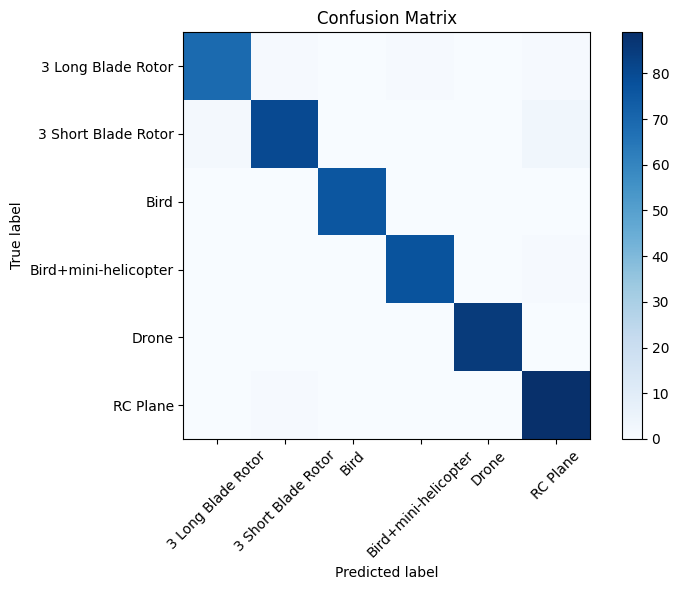

Macro Average AUC: 0.9995


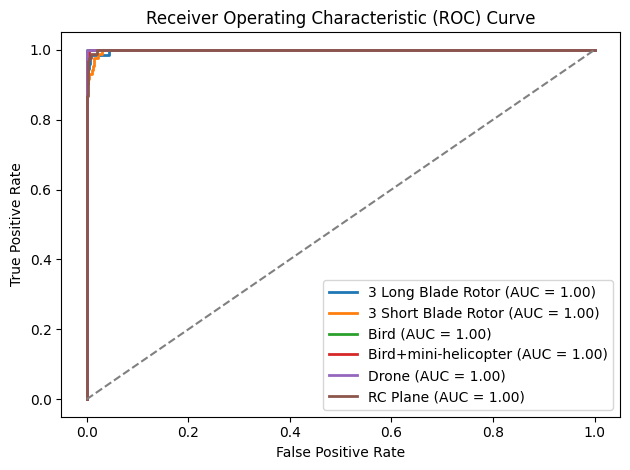

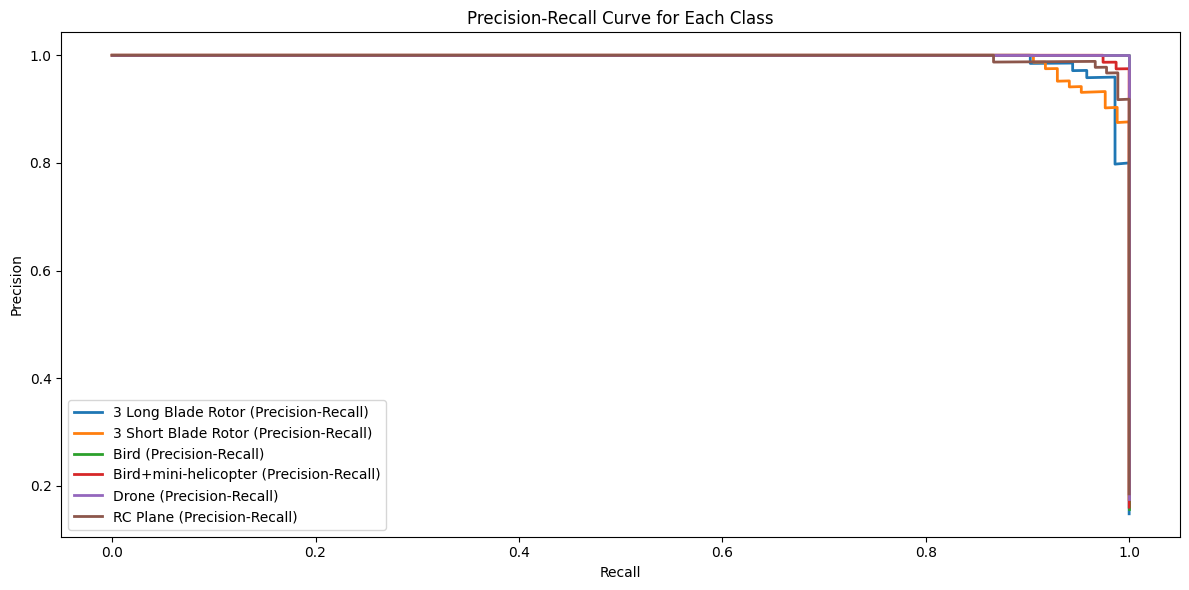

Class Distribution in Test Set: {'3 Long Blade Rotor': 72, '3 Short Blade Rotor': 85, 'Bird': 76, 'Bird+mini-helicopter': 78, 'Drone': 85, 'RC Plane': 90}
Model exported to ONNX format successfully.


In [36]:
import torch
import torch.nn as nn
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import torch.nn.functional as F
import time
import json
from sklearn.calibration import calibration_curve

# Class names for your classification task
class_names = [
    "3 Long Blade Rotor", 
    "3 Short Blade Rotor", 
    "Bird", 
    "Bird+mini-helicopter", 
    "Drone", 
    "RC Plane"
]

# Test Function with Metric Collection
def test_model(model, test_loader, criterion, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = model.to(device)
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    total_test = 0
    all_preds = []
    all_labels = []
    all_probs = []

    # Start time for inference benchmark
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device).long()

            # Forward Pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            # Store metrics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_test += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())

    # End time for inference benchmark
    end_time = time.time()
    avg_inference_time = (end_time - start_time) / len(test_loader)

    # Overall metrics
    test_loss = running_loss / total_test
    test_acc = running_corrects.double() / total_test

    print(f"Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}")
    print(f"Average Inference Time per Batch: {avg_inference_time:.4f} seconds")

    # Classification Report
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    print(report)

    # Save Classification Report to a JSON file
    with open("classification_report.json", "w") as f:
        json.dump(report, f, indent=4)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Save confusion matrix
    np.save("confusion_matrix.npy", cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    # ROC Curve & AUC (for multiclass)
    all_probs = np.array(all_probs)
    if len(class_names) > 2:
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(len(class_names)):
            fpr[i], tpr[i], _ = roc_curve((np.array(all_labels) == i).astype(int), all_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

        # Macro average AUC
        macro_auc = np.mean([auc(fpr[i], tpr[i]) for i in range(len(class_names))])
        print(f"Macro Average AUC: {macro_auc:.4f}")

        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()

    return all_labels, all_preds, all_probs, macro_auc

# Precision-Recall Curve Plot
def plot_precision_and_recall(all_labels, all_probs, class_names):
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    plt.figure(figsize=(12, 6))
    for i, class_name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve((all_labels == i).astype(int), all_probs[:, i])
        plt.plot(recall, precision, lw=2, label=f'{class_name} (Precision-Recall)')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Each Class')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

# Check for class distribution (Imbalanced Data Check)
def check_class_distribution(all_labels, class_names):
    unique, counts = np.unique(all_labels, return_counts=True)
    class_distribution = dict(zip(class_names, counts))
    print("Class Distribution in Test Set:", class_distribution)

# Example Usage
if __name__ == "__main__":
    # Initialize Model and Data
    model_deepercnn = CustomCNN(num_classes=len(class_names))
    model_deepercnn.load_state_dict(torch.load("best_model_CustomCNN.pt"))
    criterion = nn.CrossEntropyLoss()

    # Test Model
    all_labels, all_preds, all_probs, macro_auc = test_model(model_deepercnn, test_loader, criterion)

    # Plot Precision-Recall Curves
    plot_precision_and_recall(all_labels, all_probs, class_names)

    # Check for Class Imbalance
    check_class_distribution(all_labels, class_names)

    # Prepare for ONNX Conversion (Optional)
    dummy_input = torch.randn(1, 3, 224, 224, device="cuda" if torch.cuda.is_available() else "cpu")  # Adjust for your input size
    torch.onnx.export(model_deepercnn, dummy_input, "model.onnx", input_names=['input'], output_names=['output'])

    print("Model exported to ONNX format successfully.")

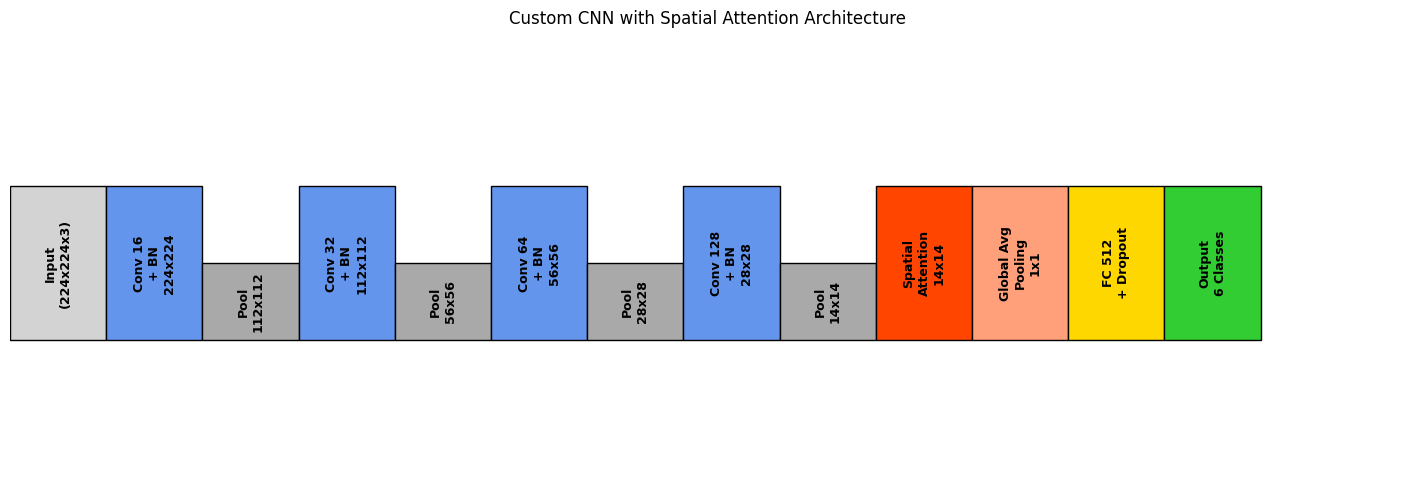

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define colors for different types of layers
colors = {
    'input': '#d3d3d3',  # Light gray for Input Layer
    'conv': '#6495ed',   # Blue for Convolution + BatchNorm + ReLU
    'pool': '#a9a9a9',   # Dark gray for Max Pooling
    'attention': '#ff4500',  # Orange for Spatial Attention Module
    'gap': '#ffa07a',    # Light Salmon for Global Average Pooling
    'dense': '#ffd700',  # Gold for Fully Connected + Dropout
    'output': '#32cd32'  # Lime for Output
}

def draw_block(ax, x, y, width, height, label, color):
    rect = patches.Rectangle((x, y), width, height, edgecolor='black', facecolor=color)
    ax.add_patch(rect)
    ax.text(x + width / 2, y + height / 2, label, color='black',
            ha='center', va='center', fontsize=9, weight="bold", rotation=90)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(18, 6))

# Block dimensions
block_width = 0.4

# Draw the Input Layer
draw_block(ax, 0, 1, block_width, 1, 'Input\n(224x224x3)', colors['input'])

# Convolutional and Pooling Layers
layers = [
    ('Conv 16\n+ BN\n224x224', block_width), ('Pool\n112x112', block_width),
    ('Conv 32\n+ BN\n112x112', block_width), ('Pool\n56x56', block_width),
    ('Conv 64\n+ BN\n56x56', block_width), ('Pool\n28x28', block_width),
    ('Conv 128\n+ BN\n28x28', block_width), ('Pool\n14x14', block_width)
]

x_offset = block_width
for layer, width in layers:
    if 'Pool' in layer:
        height = 0.5
        draw_block(ax, x_offset, 1, width, height, layer, colors['pool'])
    else:
        height = 1
        draw_block(ax, x_offset, 1, width, height, layer, colors['conv'])
    x_offset += width

# Attention Module
draw_block(ax, x_offset, 1, block_width, 1, 'Spatial\nAttention\n14x14', colors['attention'])
x_offset += block_width

# Global Average Pooling
draw_block(ax, x_offset, 1, block_width, 1, 'Global Avg\nPooling\n1x1', colors['gap'])
x_offset += block_width

# Fully Connected Layers
draw_block(ax, x_offset, 1, block_width, 1, 'FC 512\n+ Dropout', colors['dense'])
x_offset += block_width

# Output Layer
draw_block(ax, x_offset, 1, block_width, 1, 'Output\n6 Classes', colors['output'])

# Configure plot
ax.set_xlim(0, x_offset + 1)
ax.set_ylim(0, 3)
ax.axis('off')

# Title
plt.title('Custom CNN with Spatial Attention Architecture')
plt.show()